<a href="https://colab.research.google.com/github/farhanwew/GI-polyp/blob/main/yolo11/1.Notebook_Gastrointestinal_endoscopy_polyp%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import kagglehub
from google.colab import userdata
username = userdata.get('KAGGLE_USERNAME')
key = userdata.get('KAGGLE_KEY')
%env KAGGLE_USERNAME=$username
%env KAGGLE_KEY=$key

In [2]:
!kaggle datasets download farhanwew/gastrointestinal-endoscopy-polyp-dataset

Dataset URL: https://www.kaggle.com/datasets/farhanwew/gastrointestinal-endoscopy-polyp-dataset
License(s): unknown
 80% 486M/605M [00:00<00:00, 1.69GB/s]
100% 605M/605M [00:00<00:00, 1.65GB/s]


In [3]:
%pip install -q dagshub 'mlflow>=2,<3'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

In [4]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.3 MB/s eta 0:00:00


In [5]:
%%capture
!unzip gastrointestinal-endoscopy-polyp-dataset.zip

In [2]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import shutil, random
import cv2, os, glob
import numpy as np
import pandas as pd
import mlflow

In [3]:
random.seed(42)

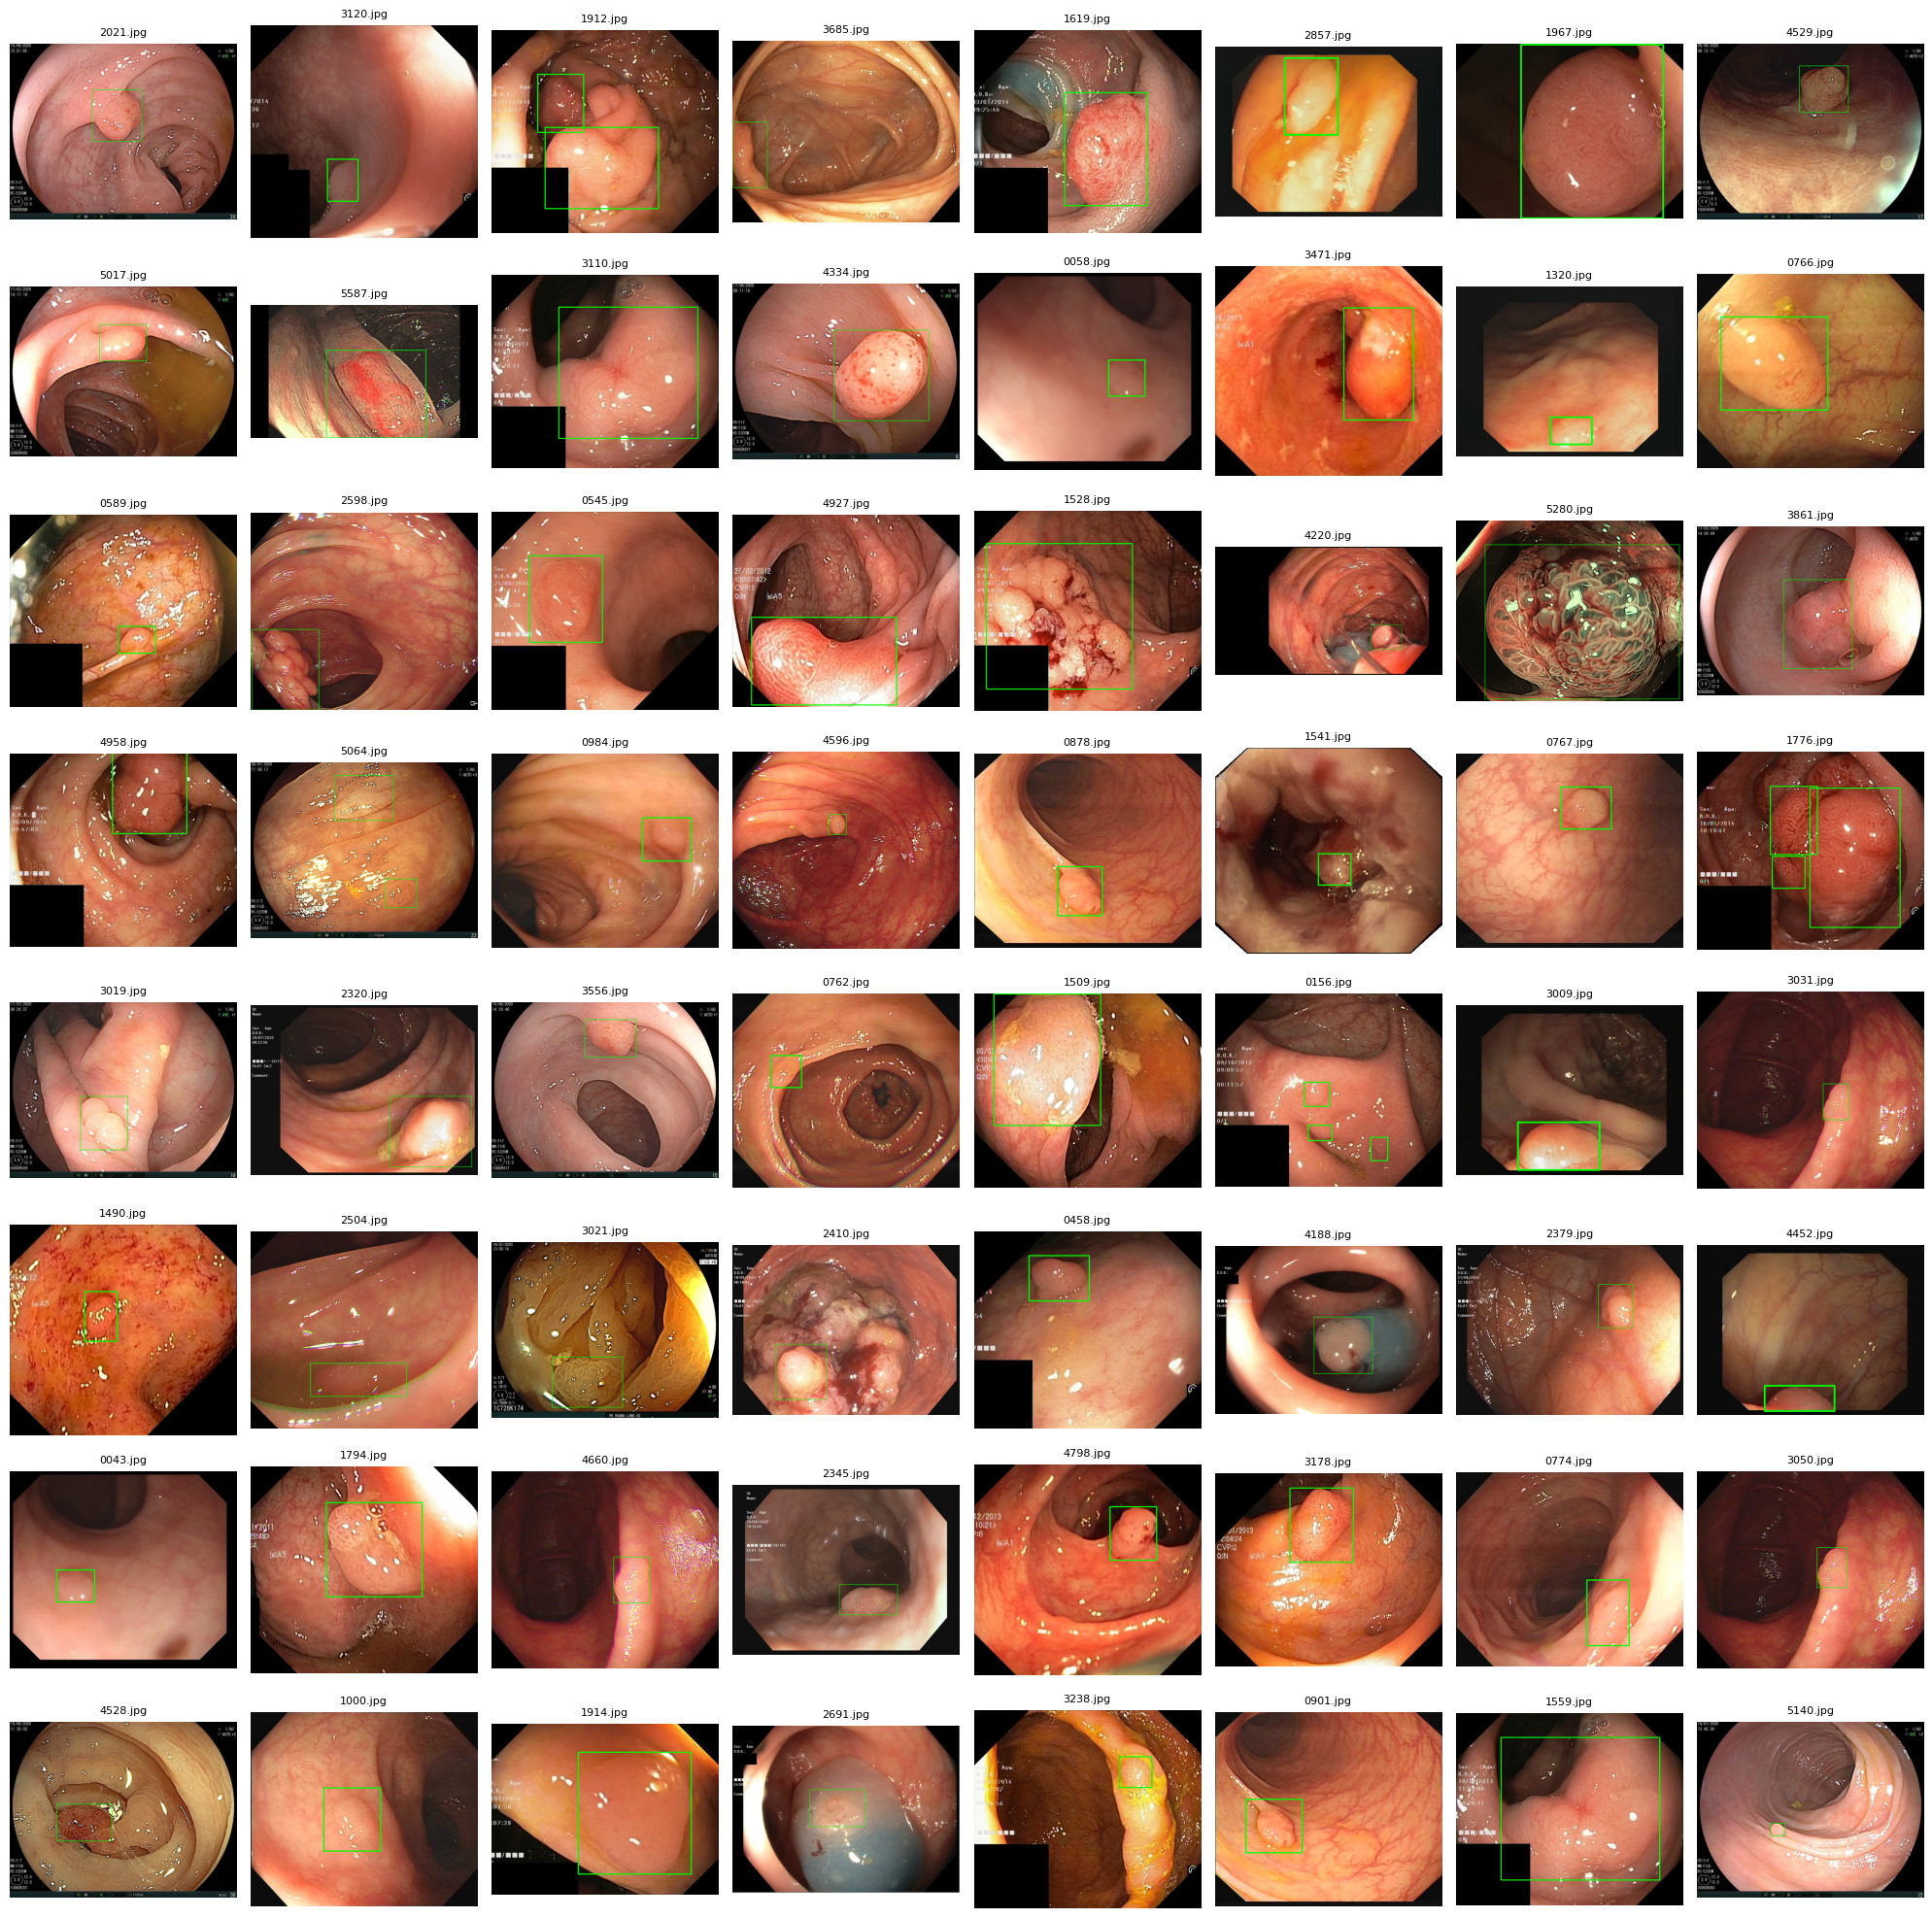

In [8]:
# === Paths ===
img_dir = "Gastrointestinal endoscopy polyp dataset/Polyp-Images"
label_dir = "Gastrointestinal endoscopy polyp dataset/TXT-Labels"

# === Ambil daftar gambar ===
images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(images)

# === Pilih 64 gambar secara acak ===
sample_images = images[:64]

# === Fungsi untuk menggambar bounding box YOLO ===
def draw_yolo_boxes(image_path, label_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    h, w, _ = img.shape
    if not os.path.exists(label_path):
        return img

    with open(label_path, "r") as f:
        for line in f:
            cls, x_center, y_center, bw, bh = map(float, line.strip().split())
            x_center, y_center, bw, bh = x_center * w, y_center * h, bw * w, bh * h
            x1 = int(x_center - bw / 2)
            y1 = int(y_center - bh / 2)
            x2 = int(x_center + bw / 2)
            y2 = int(y_center + bh / 2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === Plot 8x8 grid ===
plt.figure(figsize=(20, 20))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(img_dir, img_name)
    label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")
    img = draw_yolo_boxes(img_path, label_path)
    if img is not None:
        plt.subplot(8, 8, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(img_name), fontsize=8)

plt.tight_layout()
plt.show()

In [9]:
import os, shutil, random

# Path dataset asli
base = "Gastrointestinal endoscopy polyp dataset"
images_dir = os.path.join(base, "Polyp-Images")
labels_dir = os.path.join(base, "TXT-Labels")

# Path dataset baru (hanya train dan val)
splits = ["train", "val"]
for split in splits:
    os.makedirs(os.path.join(base, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(base, split, "labels"), exist_ok=True)

# Ambil semua file gambar
images = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
random.shuffle(images)

# Rasio pembagian
train_split = 0.8   # 80% train
val_split   = 0.2   # 20% val

n = len(images)
train_idx = int(n * train_split)

# Bagi dataset
for i, img_name in enumerate(images):
    src_img = os.path.join(images_dir, img_name)
    src_lbl = os.path.join(labels_dir, img_name.replace(".jpg", ".txt"))

    if i < train_idx:
        dst_img, dst_lbl = "train/images", "train/labels"
    else:
        dst_img, dst_lbl = "val/images", "val/labels"

    shutil.copy(src_img, os.path.join(base, dst_img, img_name))
    shutil.copy(src_lbl, os.path.join(base, dst_lbl, img_name.replace(".jpg", ".txt")))

print("✅ Dataset dibagi jadi Train/Val")

✅ Dataset dibagi jadi Train/Val


In [10]:
%%writefile data.yaml

train: /content/Gastrointestinal endoscopy polyp dataset/train/images
val: /content/Gastrointestinal endoscopy polyp dataset/val/images

nc: 1
names: ['polyp']

Writing data.yaml


In [11]:
! yolo settings mlflow=True

✅ Updated 'mlflow=True'
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": false,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [12]:
! yolo settings wandb=True

✅ Updated 'wandb=True'
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": true,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [13]:
! yolo settings tensorboard=True

✅ Updated 'tensorboard=True'
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": true,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [14]:
import dagshub
dagshub.init(repo_owner='farhanwew', repo_name='polyp-object-detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=5c93ae4d-78d7-48e8-bb66-19d5e73d806f&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=2a51003fc5780af133b769ac35756218ce7f3a70026d0bc1dd2760c470c05842




Accessing as farhanwew

Initialized MLflow to track repo "farhanwew/polyp-object-detection"

Repository farhanwew/polyp-object-detection initialized!

In [5]:
EXPERIMENT_NAME = "Percobaan_1"
PROJECT_NAME = "Model_yolo_11"
EPOCHS = 100
BATCH_SIZE = 64
IMG_SIZE = 640
MODEL = "yolo11n.pt"
DATA_PATH = "/content/data.yaml"

In [16]:
os.environ["WANDB_API_KEY"] = userdata.get('WANDB_KEY')

In [17]:
from ultralytics import YOLO
# Load a COCO-pretrained YOLOv8n model
model = YOLO(MODEL)

In [18]:
model.info()

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

In [19]:
# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data=DATA_PATH,
                      epochs=EPOCHS,
                      imgsz=IMG_SIZE,
                      batch=BATCH_SIZE,
                      name = EXPERIMENT_NAME,
                      project = PROJECT_NAME ,
                      val=True)


Ultralytics 8.3.208 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Percobaan_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

2025/10/10 01:47:18 INFO mlflow.tracking.fluent: Experiment with name 'Model_yolo_11' does not exist. Creating a new experiment.
2025/10/10 01:47:18 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/10/10 01:47:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(9512421ab7bb40d5955ba827093b1682) to https://dagshub.com/farhanwew/polyp-object-detection.mlflow
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Model_yolo_11/Percobaan_1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/100      8.25G      1.179      2.289      1.334         23        640: 100% ━━━━━━━━━━━━ 69/69 1.5it/s 46.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 0.4it/s 20.4s
                   all       1092       1204      0.751      0.436      0.577      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      2/100      9.49G      1.254      1.593      1.359         34        640: 100% ━━━━━━━━━━━━ 69/69 2.6it/s 27.0s
                 Class     Images  Instances      Box(P          R      mAP

In [6]:
BASE = "/content/Gastrointestinal endoscopy polyp dataset"
TEST_IM_DIR  = os.path.join(BASE, "val/images")
TEST_LBL_DIR = os.path.join(BASE, "val/labels")
OUT_DIR      = "/content/test_inference_overlay"
CSV_FILE     = "/content/test_metrics.csv"

os.makedirs(OUT_DIR, exist_ok=True)

# Load model terbaik
model = YOLO(f"Model_yolo_11/{EXPERIMENT_NAME}/weights/best.pt")

In [7]:
metrics = model.val(data="data.yaml", imgsz=640, batch=64, device="0")

Ultralytics 8.3.208 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1707.5±1187.4 MB/s, size: 78.6 KB)
val: Scanning /content/Gastrointestinal endoscopy polyp dataset/val/labels.cache... 1092 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1092/1092 1.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 2.0it/s 8.9s
                   all       1092       1204      0.911      0.825      0.918       0.68
Speed: 0.7ms preprocess, 2.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/runs/detect/val4
